## 0 环境信息

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("使用的设备：", torch.cuda.get_device_name(0))  # 获取第一个 CUDA 设备的名称
else:
    device = torch.device("cpu")
    print("CUDA 不可用，将使用 CPU。")

print("PyTorch 版本：", torch.__version__)
print("使用的设备类型：", device)
print("CUDA 版本：", torch.version.cuda)

2024-08-05 16:42:10.675938: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 16:42:10.706344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 16:42:11.312152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-08-05 16:42:12.401793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-05 16:42:12.429585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-05 16:42:12.429717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

使用的设备： NVIDIA RTX 3500 Ada Generation Laptop GPU
PyTorch 版本： 1.11.0
使用的设备类型： cuda
CUDA 版本： 11.3


## 1 从数据集指定场景运行闭环测试

In [2]:
# 加载场景编号
scene_idx = 5

In [3]:
import os 
import sys
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

### 1.1 加载经过处理的batch数据

In [4]:
from torch.utils.data import DataLoader, Subset
from data_modules.data_h5_womd import DataH5womd

HOME_DIR = r"/home/gz0779601/codes/DataDriven_BehaviourModels/deep_learning_model/v1.0"
DATASET = "validation"

scenario_dir = rf"{HOME_DIR}/data/h5_wosac/val_scenarios"
h5_path = rf"{HOME_DIR}/data/h5_womd_sim_agent/{DATASET}.h5"

data_module = DataH5womd(
    data_dir = "data/h5_womd_sim_agent",
    filename_train = "training",
    filename_val = "validation",
    filename_test = "testing",
    n_agent = 64,
    batch_size = 4,
    num_workers = 4,
)
data_module.setup()

# scenario_batch = data_module.val_dataset[scene_idx]
single_data_loader = DataLoader(
    Subset(data_module.val_dataset, indices=[scene_idx]),
    batch_size=1,
    num_workers=1,
    pin_memory=False,
    shuffle=False,
    drop_last=False,
    persistent_workers=True,
)
batch = next(iter(single_data_loader))

### 1.2 加载原始场景数据

In [5]:
# 从数据集加载场景
import pickle
from waymo_open_dataset.protos import scenario_pb2

with open(rf"data/h5_wosac/val_scenarios/{scene_idx}.pickle", "rb") as handle:
    scenario = scenario_pb2.Scenario.FromString(bytes.fromhex(pickle.load(handle).hex()))

### 1.3 加载规控器

In [6]:
from controller.manual import ManualController
from controller.idm import IDM

cur_controller = IDM()

### 1.4 加载模型

In [7]:
import pl_modules.waymo_motion as waymo_motion_module

CKPG_NAME = "2cti1q5z"
CKPG_VER = "v41"
# CKPG_NAME = "285yb3yb"
# CKPG_VER = "v59"

# 加载训练后的模型
ckpt_path = f"checkpoints/{CKPG_NAME}_{CKPG_VER}.ckpt"
checkpoint_version = f"yangyh408/traffic_bots/{CKPG_NAME}:{CKPG_VER}"
model = waymo_motion_module.WaymoMotion.load_from_checkpoint(
    ckpt_path, wb_artifact=checkpoint_version
)

In [37]:
import torch
import matplotlib  
matplotlib.use('TkAgg')

model.eval()
with torch.no_grad():
    rollout = model.ego_test_loop(
        batch=batch, 
        scenario=scenario, 
        controller=cur_controller, 
        sim_duration=120,
        rule_checker=False,
        visualize=True, 
        video_path=f"videos/test_{scene_idx}.mp4"
    )

frame 1: [acc= 0.728, rot= 0.000]


/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


frame 2: [acc= 0.719, rot= 0.000]
frame 3: [acc= 0.582, rot= 0.000]
frame 4: [acc= 0.422, rot= 0.000]
frame 5: [acc= 0.390, rot= 0.000]
frame 6: [acc= 0.448, rot= 0.000]
frame 7: [acc= 0.423, rot= 0.000]
frame 8: [acc= 0.306, rot= 0.000]
frame 9: [acc= 0.369, rot= 0.000]
frame 10: [acc= 0.338, rot= 0.000]
frame 11: [acc= 0.358, rot= 0.000]
frame 12: [acc= 0.296, rot= 0.000]
frame 13: [acc= 0.245, rot= 0.000]
frame 14: [acc= 0.211, rot= 0.000]
frame 15: [acc= 0.184, rot= 0.000]
frame 16: [acc= 0.162, rot= 0.000]
frame 17: [acc= 0.145, rot= 0.000]
frame 18: [acc= 0.128, rot= 0.000]
frame 19: [acc= 0.111, rot= 0.000]
frame 20: [acc= 0.096, rot= 0.000]
frame 21: [acc= 0.077, rot= 0.000]
frame 22: [acc= 0.055, rot= 0.000]
frame 23: [acc= 0.037, rot= 0.000]
frame 24: [acc= 0.020, rot= 0.000]
frame 25: [acc=-0.002, rot= 0.000]
frame 26: [acc=-0.024, rot= 0.000]
frame 27: [acc=-0.047, rot= 0.000]
frame 28: [acc=-0.070, rot= 0.000]
frame 29: [acc=-0.090, rot= 0.000]
frame 30: [acc=-0.106, rot= 

## 2 waymo地图+自定义初始状态 运行闭环测试

In [1]:
import os 
import sys
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

import torch
import tensorflow as tf
import numpy as np 

2024-08-05 17:01:27.631749: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 17:01:27.662485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 17:01:28.218797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2.1 从数据集加载原始场景信息

In [51]:
# 加载场景编号
scene_idx = 0

In [52]:
# 从数据集加载场景
import pickle
from waymo_open_dataset.protos import scenario_pb2

with open(rf"data/h5_wosac/val_scenarios/{scene_idx}.pickle", "rb") as handle:
    scenario = scenario_pb2.Scenario.FromString(bytes.fromhex(pickle.load(handle).hex()))

### 2.2 提取地图和信控信息

In [53]:
from pack_h5_womd import collate_map_features, collate_tl_features

mf_id, mf_xyz, mf_type, mf_edge = collate_map_features(scenario.map_features)
tl_lane_state, tl_lane_id, tl_stop_point = collate_tl_features(scenario.dynamic_map_states)

In [54]:
# 地图相关信息格式

print(mf_id)
print(len(mf_id))

print(mf_xyz)
print(len(mf_xyz), len(mf_xyz[0]), len(mf_xyz[0][0]))

print(mf_type)
print(len(mf_type))

print(mf_edge)
print(len(mf_edge), len(mf_edge[0]))

[3, 5, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 73, 82, 95, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 153, 154, 155, 156, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 183, 183, 183, 183, 184, 184, 184, 184, 185, 185, 185, 185, 186, 186, 186, 186, 187, 187, 187, 187, 188, 188, 188, 188, 190, 190, 190, 190, 191, 191, 191, 191, 192, 192, 192, 192, 193, 193, 193, 193, 194, 194, 194, 194, 195, 195, 195, 195, 196, 196, 196, 196, 197, 197, 197, 197, 198, 198, 198, 198, 199, 199, 199, 199, 200, 200, 200, 200, 201, 201, 201, 201, 202, 202, 202, 202, 203, 203, 203, 203, 204, 204, 204, 204, 205, 205

In [55]:
# 信控相关信息格式

print(tl_lane_state)
print(len(tl_lane_state), len(tl_lane_state[0]))

print(tl_lane_id)
print(len(tl_lane_id), len(tl_lane_id[0]))

print(tl_stop_point)
print(len(tl_stop_point), len(tl_stop_point[0]), len(tl_stop_point[0][0]))

[[3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [3, 3, 3, 3], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1

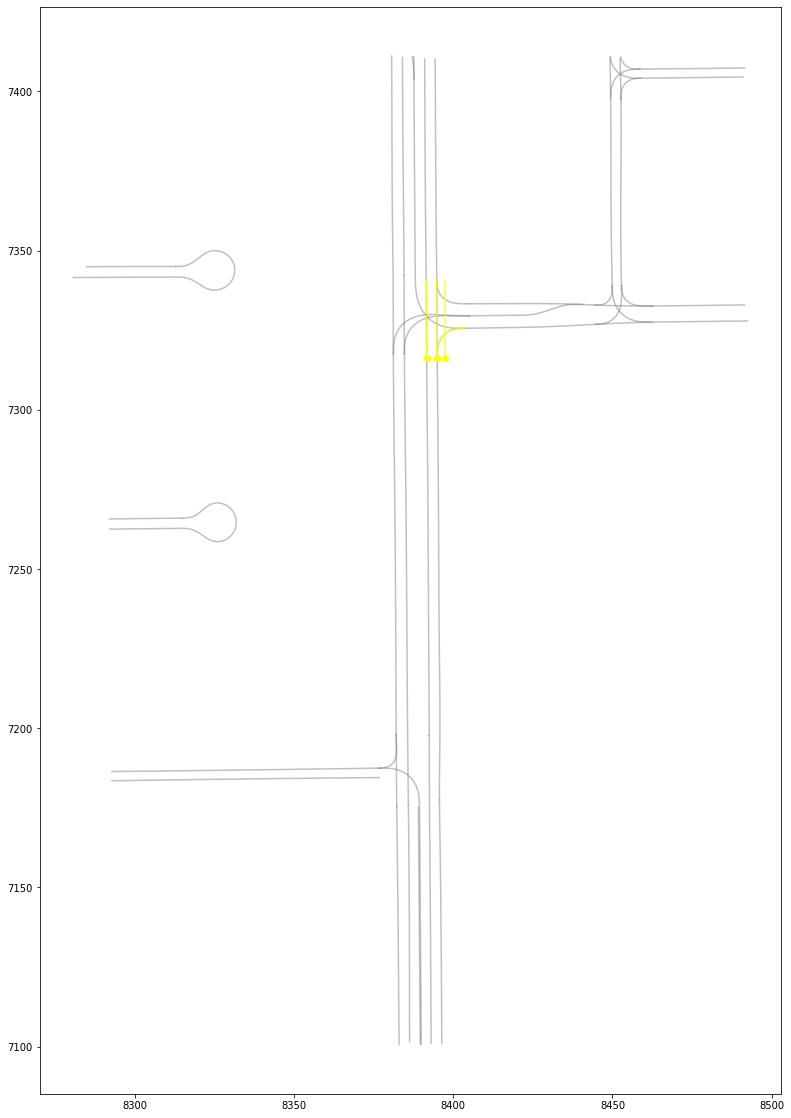

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.set_aspect('equal') 

# 绘制道路中心线
for i in range(len(mf_id)):
    if mf_type[i] == 1:
        link = mf_xyz[i]
        plt.plot([p[0] for p in link], [p[1] for p in link], '-', alpha=0.5, color='grey')
        # plt.text(link[int(len(link) / 2)][0], link[int(len(link) / 2)][1], str(mf_id[i]), ha='center', va='center', fontsize=8, color='black')

# 绘制某一帧的信控状态
frame = 50
light_color = ['blue', 'red', 'yellow', 'green', 'blue']
for i in range(len(tl_lane_id[frame])):
    lane_idx = np.where(np.array(mf_id) == tl_lane_id[frame][i])[0][0]
    lane_xyz = mf_xyz[lane_idx]
    plt.plot([p[0] for p in lane_xyz], [p[1] for p in lane_xyz], '-', alpha=0.8, color=light_color[tl_lane_state[frame][i]])
    plt.plot(tl_stop_point[frame][i][0], tl_stop_point[frame][i][1], 'o', alpha=1, color=light_color[tl_lane_state[frame][i]])

plt.show()

### 2.3.1 提取代理信息

In [57]:
"""方式一：从原场景提取代理信息"""

from pack_h5_womd import collate_agent_features

agent_id, agent_type, agent_states, agent_role = collate_agent_features(
    scenario.tracks,
    sdc_track_index=scenario.sdc_track_index,
    track_index_predict=[i.track_index for i in scenario.tracks_to_predict],
    object_id_interest=[i for i in scenario.objects_of_interest],
)

# id [agent_num]
print(np.array(agent_id).shape)

# type [agent_num]
# [TYPE_VEHICLE=0, TYPE_PEDESTRIAN=1, TYPE_CYCLIST=2]
print(np.array(agent_type).shape)

# state [agent_num, frames, 10]
# [center_x, center_y, center_z, length, width, height, heading, velocity_x, velocity_y, valid]
print(np.array(agent_states).shape)

# role [agent_num, 3]
# 0 - 是否为主车
# 1 - 是否为objects_of_interest（可能对研究训练有用的行为的对象）
# 2 - 是否为tracks_to_predict（必须预测的对象，仅在训练集和验证集中提供）
print(np.array(agent_role).shape)

(11,)
(11,)
(11, 91, 10)
(11, 3)


### 2.3.2 设置代理信息

In [58]:
"""方式二：自定义代理信息"""

# id [agent_num]
agent_id = [369, 370, 371, 372, 556]

# type [agent_num]
# [TYPE_VEHICLE=0, TYPE_PEDESTRIAN=1, TYPE_CYCLIST=2]
agent_type = [0, 0, 0, 0, 0]

# role [agent_num, 3]
# 0 - 是否为主车
# 1 - 是否为objects_of_interest（可能对研究训练有用的行为的对象）
# 2 - 是否为tracks_to_predict（必须预测的对象，仅在训练集和验证集中提供）
agent_role = [
    [False, False, False],
    [False, False, True],
    [False, False, False],
    [False, False, False],
    [True, False, False]
]

# states [agent_num, frames, 10]
# [center_x, center_y, center_z, length, width, height, heading, velocity_x, velocity_y, valid]
agent_states = [
    [[8395.5048828125, 7249.99609375, -14.010635375976562, 4.756037712097168, 2.0462944507598877, 1.6023485660552979, 1.5822010040283203, -0.3125, 19.326171875, True], [8395.4736328125, 7251.9287109375, -14.000516163384034, 4.76189661026001, 2.0593159198760986, 1.6107460260391235, 1.585012435913086, -0.3125, 19.326171875, True], [8395.431640625, 7253.8505859375, -13.998344045855672, 4.739120006561279, 2.0614328384399414, 1.619963526725769, 1.583803415298462, -0.419921875, 19.21875, True], [8395.4013671875, 7255.80859375, -14.015545551811453, 4.771324634552002, 2.0703282356262207, 1.6340086460113525, 1.5805013179779053, -0.302734375, 19.580078125, True], [8395.3798828125, 7257.7041015625, -14.036089769789383, 4.775165557861328, 2.0761101245880127, 1.6181843280792236, 1.578407645225525, -0.21484375, 18.955078125, True], [8395.35546875, 7259.6025390625, -14.01985303451912, 4.774107456207275, 2.0866475105285645, 1.652348279953003, 1.588748812675476, -0.244140625, 18.984375, True], [8395.349609375, 7261.51171875, -14.038302999529211, 4.753843784332275, 2.082709312438965, 1.6332414150238037, 1.5885826349258423, -0.05859375, 19.091796875, True], [8395.3271484375, 7263.4248046875, -14.058067530551314, 4.747679233551025, 2.087566614151001, 1.6209542751312256, 1.5893115997314453, -0.224609375, 19.130859375, True], [8395.2841796875, 7265.3115234375, -14.074770327401692, 4.710694789886475, 2.0733964443206787, 1.6461181640625, 1.5896310806274414, -0.4296875, 18.8671875, True], [8395.2529296875, 7267.17919921875, -14.071941190266063, 4.6964521408081055, 2.059957265853882, 1.6449100971221924, 1.585894227027893, -0.3125, 18.6767578125, True], [8395.2197265625, 7269.10791015625, -14.083323505194313, 4.745246410369873, 2.0748298168182373, 1.6331822872161865, 1.590860366821289, -0.33203125, 19.287109375, True]],
    [[8396.10546875, 7154.03076171875, -13.450148582458496, 5.133871555328369, 2.203359365463257, 1.6165982484817505, 1.5685367584228516, 0.13671875, 21.376953125, True], [8396.119140625, 7156.16845703125, -13.444271313225343, 5.091489315032959, 2.2021641731262207, 1.6125479936599731, 1.563308596611023, 0.13671875, 21.376953125, True], [8396.1376953125, 7158.24462890625, -13.432815176226766, 5.096654415130615, 2.1918182373046875, 1.587924838066101, 1.567080020904541, 0.185546875, 20.76171875, True], [8396.123046875, 7160.42724609375, -13.464530651603933, 5.138164043426514, 2.2315266132354736, 1.592545747756958, 1.567673683166504, -0.146484375, 21.826171875, True], [8396.12109375, 7162.57958984375, -13.448625437208817, 5.110944747924805, 2.2167716026306152, 1.5978059768676758, 1.5649570226669312, -0.01953125, 21.5234375, True], [8396.10546875, 7164.7529296875, -13.49083177139656, 5.104405879974365, 2.2150659561157227, 1.5922120809555054, 1.564302682876587, -0.15625, 21.7333984375, True], [8396.1015625, 7166.8642578125, -13.483409505876867, 5.084568023681641, 2.212529182434082, 1.6014478206634521, 1.580500841140747, -0.0390625, 21.11328125, True], [8396.0947265625, 7169.013671875, -13.516496867099166, 5.117166042327881, 2.199558973312378, 1.6021273136138916, 1.5702431201934814, -0.068359375, 21.494140625, True], [8396.0908203125, 7171.1484375, -13.504861231637532, 5.035835266113281, 2.1944468021392822, 1.5906894207000732, 1.5694551467895508, -0.0390625, 21.34765625, True], [8396.0830078125, 7173.26025390625, -13.515580945515087, 5.100960731506348, 2.2359704971313477, 1.6081032752990723, 1.56867253780365, -0.078125, 21.1181640625, True], [8396.06640625, 7175.42333984375, -13.496037509710915, 5.0914740562438965, 2.2275919914245605, 1.6015872955322266, 1.5792957544326782, -0.166015625, 21.630859375, True]],
    [[8392.181640625, 7235.14306640625, -13.830416679382324, 4.693872451782227, 2.0756969451904297, 1.5766584873199463, 1.5732872486114502, -0.1171875, 18.7109375, True], [8392.169921875, 7237.01416015625, -13.838374363457277, 4.681710720062256, 2.0667858123779297, 1.5723609924316406, 1.5711127519607544, -0.1171875, 18.7109375, True], [8392.177734375, 7238.86328125, -13.843545538165243, 4.7035932540893555, 2.078188180923462, 1.5730082988739014, 1.5785671472549438, 0.078125, 18.4912109375, True], [8392.171875, 7240.6875, -13.843564693962332, 4.66843843460083, 2.0769972801208496, 1.5871800184249878, 1.5767985582351685, -0.05859375, 18.2421875, True], [8392.16796875, 7242.51025390625, -13.850698343702957, 4.6832075119018555, 2.082688808441162, 1.5789870023727417, 1.5782173871994019, -0.0390625, 18.2275390625, True], [8392.1611328125, 7244.34619140625, -13.853792586826248, 4.724412441253662, 2.0911755561828613, 1.5947036743164062, 1.5796922445297241, -0.068359375, 18.359375, True], [8392.15625, 7246.17822265625, -13.871447187456457, 4.7202839851379395, 2.0909836292266846, 1.591770887374878, 1.5785704851150513, -0.048828125, 18.3203125, True], [8392.1435546875, 7247.990234375, -13.89080068484819, 4.704876899719238, 2.0847349166870117, 1.5879217386245728, 1.5807387828826904, -0.126953125, 18.1201171875, True], [8392.130859375, 7249.81494140625, -13.903387423348958, 4.704655647277832, 2.0848331451416016, 1.5925785303115845, 1.5814419984817505, -0.126953125, 18.2470703125, True], [8392.1220703125, 7251.6357421875, -13.920621686481883, 4.697376251220703, 2.0858945846557617, 1.5977681875228882, 1.5784320831298828, -0.087890625, 18.2080078125, True], [8392.1162109375, 7253.4599609375, -13.920165088446266, 4.715240955352783, 2.0954883098602295, 1.6111465692520142, 1.5782873630523682, -0.05859375, 18.2421875, True]],
    [[8392.6533203125, 7174.14501953125, -13.4308500289917, 4.81757116317749, 2.0840933322906494, 1.5348986387252808, 1.5724315643310547, 0.078125, 17.548828125, True], [8392.6611328125, 7175.89990234375, -13.443473087822511, 4.858018398284912, 2.1152150630950928, 1.5546501874923706, 1.5757981538772583, 0.078125, 17.548828125, True], [8392.654296875, 7177.6904296875, -13.443202596881063, 4.834859371185303, 2.1077427864074707, 1.5157395601272583, 1.5744959115982056, -0.068359375, 17.9052734375, True], [8392.640625, 7179.419921875, -13.450582211052176, 4.84534215927124, 2.092646360397339, 1.5199711322784424, 1.5743408203125, -0.13671875, 17.294921875, True], [8392.6220703125, 7181.13818359375, -13.463391176649735, 4.890226364135742, 2.113778829574585, 1.5292786359786987, 1.5733261108398438, -0.185546875, 17.1826171875, True], [8392.603515625, 7182.9052734375, -13.475655951999588, 4.865891456604004, 2.111224412918091, 1.5349719524383545, 1.5736961364746094, -0.185546875, 17.6708984375, True], [8392.576171875, 7184.65380859375, -13.487830740007727, 4.859665870666504, 2.1141223907470703, 1.5380562543869019, 1.582428216934204, -0.2734375, 17.4853515625, True], [8392.5615234375, 7186.390625, -13.49995252505815, 4.846556663513184, 2.100978136062622, 1.5447444915771484, 1.5824164152145386, -0.146484375, 17.3681640625, True], [8392.5595703125, 7188.08642578125, -13.514174815011556, 4.886437892913818, 2.120779514312744, 1.5530259609222412, 1.5744459629058838, -0.01953125, 16.9580078125, True], [8392.533203125, 7189.85693359375, -13.53062897255366, 4.878307819366455, 2.1198782920837402, 1.5357599258422852, 1.575266718864441, -0.263671875, 17.705078125, True], [8392.513671875, 7191.58544921875, -13.522732761175758, 4.912601470947266, 2.1399970054626465, 1.5449631214141846, 1.5798118114471436, -0.1953125, 17.28515625, True]],
    [[8392.410571507779, 7202.185541983308, -13.144874041140794, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5756219625473022, -0.08884891867637634, 18.20938491821289, True], [8392.401683171454, 7204.007186346924, -13.15710868576702, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5759450197219849, -0.08954513072967529, 18.22984504699707, True], [8392.392658314086, 7205.832362924224, -13.165779654191589, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.576280951499939, -0.09516873210668564, 18.27100944519043, True], [8392.382652888338, 7207.6607696605215, -13.175107580238956, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5764985084533691, -0.10137411952018738, 18.307140350341797, True], [8392.37238727034, 7209.493098445325, -13.18746239938947, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5765782594680786, -0.09894900023937225, 18.338048934936523, True], [8392.36286564337, 7211.327881404639, -13.197656493381832, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5766102075576782, -0.09478527307510376, 18.3569393157959, True], [8392.35343316377, 7213.163918421533, -13.205582912724745, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5766372680664062, -0.09327118843793869, 18.36125946044922, True], [8392.344211114769, 7215.000191170081, -13.215478621050638, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5766922235488892, -0.09516789019107819, 18.364782333374023, True], [8392.334398732912, 7216.837037891057, -13.228209585335383, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5766382217407227, -0.0965147539973259, 18.374237060546875, True], [8392.324907212298, 7218.675219194855, -13.238801678645427, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5766737461090088, -0.09474021941423416, 18.38309669494629, True], [8392.315450503396, 7220.5136930799345, -13.248955714300955, 5.285999774932861, 2.3320000171661377, 2.3299999237060547, 1.5767649412155151, -0.0999351516366005, 18.378984451293945, True]]
]


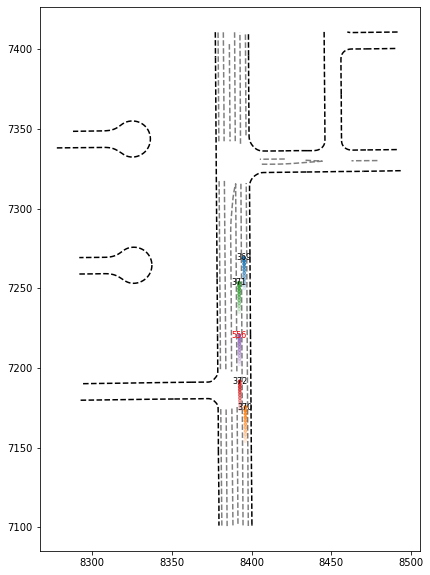

In [59]:
import matplotlib.pyplot as plt
from waymo_open_dataset.utils.sim_agents import visualizations
from utils.transform_utils import torch_pos2global, torch_rad2rot, torch_rad2global

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect('equal') 

# 绘制静态地图
visualizations.add_map(ax, scenario)

# 绘制代理
history_length = 11
agent_states = np.array(agent_states)[:, :history_length, :]
alpha_values = np.linspace(0.1, 1.0, history_length)  
for i in range(len(agent_id)):
    if not np.any(agent_states[i, :, -1] == 0):
        plt.scatter(agent_states[i, :, 0], agent_states[i, :, 1], s=8, marker='o', alpha=alpha_values)  
    if (agent_role[i][0]):
        plt.text(agent_states[i, -1, 0], agent_states[i, -1, 1], str(agent_id[i]), ha='center', va='center', fontsize=8, color='red')
    else:
        plt.text(agent_states[i, -1, 0], agent_states[i, -1, 1], str(agent_id[i]), ha='center', va='center', fontsize=8, color='black')

plt.show()

### 2.4 将上述提取的信息预处理为batch数据

In [60]:
import src.utils.pack_h5 as pack_utils

N_PL_TYPE = 11
DIM_VEH_LANES = [0, 1, 2]
DIM_CYC_LANES = [3]
DIM_PED_LANES = [4]

N_TL_STATE = 5

N_PL_MAX = 3000
N_TL_MAX = 40
N_AGENT_MAX = 1300

N_PL = 1024
N_TL = 100
N_AGENT = 64
N_AGENT_NO_SIM = 256

THRESH_MAP = 500  # ! 120
THRESH_AGENT = 120

N_STEP = 91
STEP_CURRENT = 10

pack_all = False
pack_history = True


episode = {}
n_pl = pack_utils.pack_episode_map(
    episode=episode, mf_id=mf_id, mf_xyz=mf_xyz, mf_type=mf_type, mf_edge=mf_edge, n_pl_max=N_PL_MAX
)
n_tl = pack_utils.pack_episode_traffic_lights(
    episode=episode,
    tl_lane_state=tl_lane_state,
    tl_lane_id=tl_lane_id,
    tl_stop_point=tl_stop_point,
    pack_all=pack_all,
    pack_history=pack_history,
    n_tl_max=N_TL_MAX,
    step_current=STEP_CURRENT,
)
n_agent = pack_utils.pack_episode_agents(
    episode=episode,
    agent_id=agent_id,
    agent_type=agent_type,
    agent_states=agent_states,
    agent_role=agent_role,
    pack_all=pack_all,
    pack_history=pack_history,
    n_agent_max=N_AGENT_MAX,
    step_current=STEP_CURRENT,
)
scenario_center, scenario_yaw = pack_utils.center_at_sdc(episode)

episode_reduced = {}
pack_utils.filter_episode_map(episode, N_PL, THRESH_MAP, thresh_z=5)
episode_with_map = episode["map/valid"].any(1).sum() > 0
pack_utils.repack_episode_map(episode, episode_reduced, N_PL, N_PL_TYPE)

pack_utils.filter_episode_traffic_lights(episode)
pack_utils.repack_episode_traffic_lights(episode, episode_reduced, N_TL, N_TL_STATE)

mask_sim, mask_no_sim = pack_utils.filter_episode_agents(
    episode=episode,
    episode_reduced=episode_reduced,
    n_agent=N_AGENT,
    prefix="history/",
    dim_veh_lanes=DIM_VEH_LANES,
    dist_thresh_agent=THRESH_AGENT,
    step_current=STEP_CURRENT,
)
episode_reduced["map/boundary"] = pack_utils.get_map_boundary(
    episode_reduced["map/valid"], episode_reduced["map/pos"]
)

pack_utils.repack_episode_agents(episode, episode_reduced, mask_sim, N_AGENT, "history/")
pack_utils.repack_episode_agents_no_sim(
    episode, episode_reduced, mask_no_sim, N_AGENT_NO_SIM, "history/"
)

In [61]:
n_step = 91
n_step_history = 11
n_agent = 64
n_agent_no_sim = 256
n_pl = 1024
n_tl = 100
n_tl_stop = 40
n_pl_node = 20

tensor_size_test = {
    # object_id for waymo metrics
    "history/agent/object_id": (n_agent,),
    "history/agent_no_sim/object_id": (n_agent_no_sim,),
    # agent_sim
    "history/agent/valid": (n_step_history, n_agent),  # bool,
    "history/agent/pos": (n_step_history, n_agent, 2),  # float32
    "history/agent/z": (n_step_history, n_agent, 1),  # float32
    "history/agent/vel": (n_step_history, n_agent, 2),  # float32, v_x, v_y
    "history/agent/spd": (n_step_history, n_agent, 1),  # norm of vel, signed using yaw_bbox and vel_xy
    "history/agent/acc": (n_step_history, n_agent, 1),  # m/s2, acc[t] = (spd[t]-spd[t-1])/dt
    "history/agent/yaw_bbox": (n_step_history, n_agent, 1),  # float32, yaw of the bbox heading
    "history/agent/yaw_rate": (n_step_history, n_agent, 1),  # rad/s, yaw_rate[t] = (yaw[t]-yaw[t-1])/dt
    "history/agent/type": (n_agent, 3),  # bool one_hot [Vehicle=0, Pedestrian=1, Cyclist=2]
    "history/agent/role": (n_agent, 3),  # bool [sdc=0, interest=1, predict=2]
    "history/agent/size": (n_agent, 3),  # float32: [length, width, height]
    "history/agent_no_sim/valid": (n_step_history, n_agent_no_sim),
    "history/agent_no_sim/pos": (n_step_history, n_agent_no_sim, 2),
    "history/agent_no_sim/z": (n_step_history, n_agent_no_sim, 1),
    "history/agent_no_sim/vel": (n_step_history, n_agent_no_sim, 2),
    "history/agent_no_sim/spd": (n_step_history, n_agent_no_sim, 1),
    "history/agent_no_sim/yaw_bbox": (n_step_history, n_agent_no_sim, 1),
    "history/agent_no_sim/type": (n_agent_no_sim, 3),
    "history/agent_no_sim/size": (n_agent_no_sim, 3),
    # map
    "map/valid": (n_pl, n_pl_node),  # bool
    "map/type": (n_pl, 11),  # bool one_hot
    "map/pos": (n_pl, n_pl_node, 2),  # float32
    "map/dir": (n_pl, n_pl_node, 2),  # float32
    "map/boundary": (4,),  # xmin, xmax, ymin, ymax
    # traffic_light
    "history/tl_lane/valid": (n_step_history, n_tl),  # bool
    "history/tl_lane/state": (n_step_history, n_tl, 5),  # bool one_hot
    "history/tl_lane/idx": (n_step_history, n_tl),  # int, -1 means not valid
    "history/tl_stop/valid": (n_step_history, n_tl_stop),  # bool
    "history/tl_stop/state": (n_step_history, n_tl_stop, 5),  # bool one_hot
    "history/tl_stop/pos": (n_step_history, n_tl_stop, 2),  # x,y
    "history/tl_stop/dir": (n_step_history, n_tl_stop, 2),  # dx,dy
}

In [62]:
batch = {
    "episode_idx": str(0),
    "scenario_id": scenario.scenario_id,
    "scenario_center": torch.Tensor([scenario_center]),
    "scenario_yaw": torch.Tensor(np.array([scenario_yaw])),
    "with_map": torch.Tensor([episode_with_map]),
}
for k, _size in tensor_size_test.items():
    batch[k] = torch.from_numpy(np.ascontiguousarray(episode_reduced[k]))[tf.newaxis]

/tmp/ipykernel_20346/137076146.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "with_map": torch.Tensor([episode_with_map]),


### 2.5 绘制初始车辆及轨迹信息

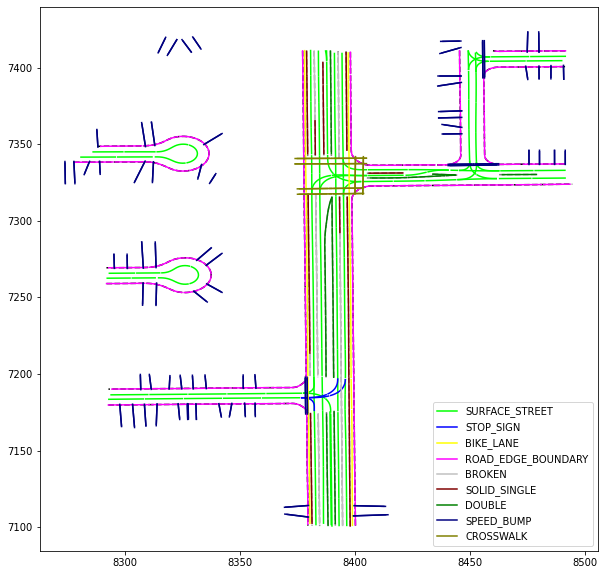

In [63]:
import matplotlib.pyplot as plt
from waymo_open_dataset.utils.sim_agents import visualizations
from utils.transform_utils import torch_pos2global, torch_rad2rot, torch_dir2global

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 绘制静态地图
visualizations.add_map(ax, scenario)

# 绘制目标线段
scenario_center = batch["scenario_center"].unsqueeze(1)  # [n_sc, 1, 2]
scenario_rot = torch_rad2rot(batch["scenario_yaw"])  # [n_sc, 2, 2]

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#C0C0C0', '#800000', '#008000', '#000080', '#808000']  
types = ["FREEWAY", "SURFACE_STREET", "STOP_SIGN", "BIKE_LANE", "ROAD_EDGE_BOUNDARY", "ROAD_EDGE_MEDIAN", "BROKEN", "SOLID_SINGLE", "DOUBLE", "SPEED_BUMP", "CROSSWALK"]
plot_type = [False] * len(types)

for cur_type in range(len(types)):
# for cur_type in [1]:
    for i in range(batch['map/valid'].shape[1]):
        if tf.argmax(batch['map/type'], axis=-1)[0, i] == cur_type and tf.reduce_any(batch['map/valid'][0, i]):
            nodes_pos = torch_pos2global(batch['map/pos'][:, i][batch['map/valid'][:, i]], scenario_center, scenario_rot)
            if plot_type[cur_type]:
                plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type])
            else:
                plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type], label=types[cur_type])
                plot_type[cur_type] = True
            
            # plt.text(nodes_pos[0, int(nodes_pos.shape[1]/2), 0], nodes_pos[0, int(nodes_pos.shape[1]/2), 1], i, ha='center', va='center', fontsize=8, color='black')
            
            # 展示每个点的dir信息
            # nodes_yaw = torch_dir2global(batch['map/dir'][:, i][batch['map/valid'][:, i]], scenario_rot)
            # for k in range(nodes_pos.shape[1]):
            #     plt.plot([nodes_pos[0, k, 0], nodes_pos[0, k, 0] + nodes_yaw[0, k, 0]*15], 
            #             [nodes_pos[0, k, 1], nodes_pos[0, k, 1] + nodes_yaw[0, k, 1]*15], '-', linewidth=1, color='#653700')

plt.legend()
plt.show()

### 2.6 为每个代理设置期望目的地

In [64]:
# 设定每个代理的期望终点
goal_expect = [239, 269, 269, 269, 269]

# 验证代理终点信息
valid_agent_id = batch['history/agent/object_id'][batch['history/agent/valid'].any(1)]
assert valid_agent_id.shape[0] == len(goal_expect)

for id, goal in zip(valid_agent_id, goal_expect):
    print(f"{id} -d-> {goal}")

556 -d-> 239
370 -d-> 269
371 -d-> 269
372 -d-> 269
369 -d-> 269


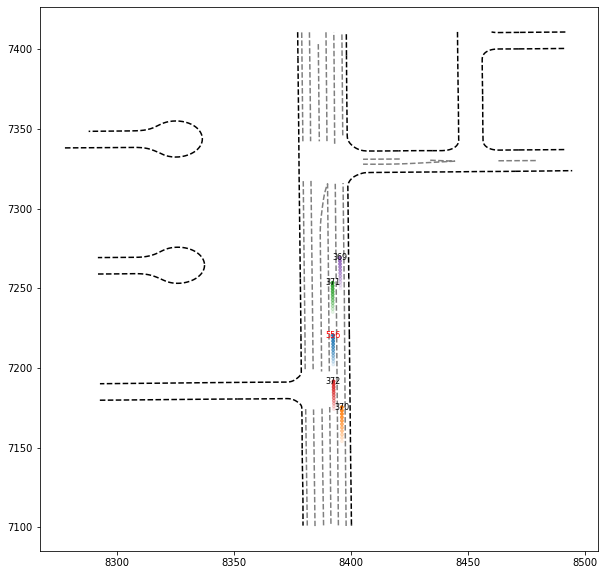

In [65]:
# 绘制代理终点情况
import matplotlib.pyplot as plt
from waymo_open_dataset.utils.sim_agents import visualizations
from utils.transform_utils import torch_pos2global, torch_rad2rot, torch_rad2global

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 绘制静态地图
visualizations.add_map(ax, scenario)

scenario_center = batch["scenario_center"].unsqueeze(1)  # [n_sc, 1, 2]
scenario_rot = torch_rad2rot(batch["scenario_yaw"])  # [n_sc, 2, 2]


# 绘制代理
agent_history_global = torch_pos2global(batch['history/agent/pos'], scenario_center, scenario_rot)[0]
alpha_values = np.linspace(0.1, 1.0, agent_history_global.shape[0]) 

for i in range(agent_history_global.shape[1]):
    x = agent_history_global[:, i, 0][batch['history/agent/valid'][0, :, i]]
    y = agent_history_global[:, i, 1][batch['history/agent/valid'][0, :, i]]
    if x.shape[0] > 0 and y.shape[0] > 0:
        plt.scatter(x, y, s=8, marker='o', alpha=alpha_values)
        if (batch['history/agent/role'][0, i, 0]):
            plt.text(x[-1], y[-1], str(int(batch['history/agent/object_id'][0, i])), ha='center', va='center', fontsize=8, color='red')
        else:
            plt.text(x[-1], y[-1], str(int(batch['history/agent/object_id'][0, i])), ha='center', va='center', fontsize=8, color='black')

# 绘制终点
for i in goal_expect:
    if tf.argmax(batch['map/type'], axis=-1)[0, i] == cur_type and tf.reduce_any(batch['map/valid'][0, i]):
        nodes_pos = torch_pos2global(batch['map/pos'][:, i][batch['map/valid'][:, i]], scenario_center, scenario_rot)
        if plot_type[cur_type]:
            plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type])
        else:
            plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type], label=types[cur_type])
            plot_type[cur_type] = True
        
        plt.text(nodes_pos[0, int(nodes_pos.shape[1]/2), 0], nodes_pos[0, int(nodes_pos.shape[1]/2), 1], i, ha='center', va='center', fontsize=8, color='black')

plt.show()
            

### 2.7 加载规控器

In [66]:
from controller.manual import ManualController
from controller.idm import IDM

cur_controller = IDM()

### 2.8 加载模型

In [67]:
import pl_modules.waymo_motion as waymo_motion_module

CKPG_NAME = "2cti1q5z"
CKPG_VER = "v41"
# CKPG_NAME = "285yb3yb"
# CKPG_VER = "v59"

# 加载训练后的模型
ckpt_path = f"checkpoints/{CKPG_NAME}_{CKPG_VER}.ckpt"
checkpoint_version = f"yangyh408/traffic_bots/{CKPG_NAME}:{CKPG_VER}"
model = waymo_motion_module.WaymoMotion.load_from_checkpoint(
    ckpt_path, wb_artifact=checkpoint_version
)

In [96]:
import torch
import matplotlib  
matplotlib.use('TkAgg')

model.eval()
with torch.no_grad():
    rollout = model.ego_test_loop(
        origin_batch=batch, 
        scenario=scenario, 
        controller=cur_controller, 
        goal = goal_expect,
        sim_duration=90,
        k_futures = 1,
        print_info=False,
        rule_checker=False,
        visualize=False,
        video_path=f"videos/test_{batch['episode_idx'][0]}.mp4"
    )

## 3 onsite场景 运行闭环测试

In [2]:
import os 
import sys
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

import torch
import tensorflow as tf
import numpy as np 

2024-08-06 16:11:09.791221: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 16:11:09.821216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 16:11:10.364915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
scenario_id = "0_140_straight_straight_141"
scenario_dir = f"./data/onsite_replay/{scenario_id}"

for file_name in os.listdir(scenario_dir):
    if not file_name.startswith('.') and file_name.endswith('xodr'):
        xodr_path = os.path.join(scenario_dir, file_name)
    if not file_name.startswith('.') and file_name.endswith('xosc'):
        xosc_path = os.path.join(scenario_dir, file_name)

### 3.1 加载规控器

In [4]:
from controller.manual import ManualController
from controller.idm import IDM

cur_controller = IDM()

### 3.2 加载模型

In [5]:
import pl_modules.waymo_motion as waymo_motion_module

CKPG_NAME = "2cti1q5z"
CKPG_VER = "v41"
# CKPG_NAME = "285yb3yb"
# CKPG_VER = "v59"

# 加载训练后的模型
ckpt_path = f"checkpoints/{CKPG_NAME}_{CKPG_VER}.ckpt"
checkpoint_version = f"yangyh408/traffic_bots/{CKPG_NAME}:{CKPG_VER}"
model = waymo_motion_module.WaymoMotion.load_from_checkpoint(
    ckpt_path, wb_artifact=checkpoint_version
)

2024-08-06 16:11:16.815663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 16:11:16.816178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 16:11:16.816312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 3.3 通过xodr获取地图信息

In [6]:
from lxml import etree
from utils.opendrive2discretenet.opendriveparser.parser import parse_opendrive as parse_opendrive_xml
from utils.opendrive2discretenet.network import Network

In [7]:
with open(xodr_path, 'r', encoding='utf-8') as fh:
    root = etree.parse(fh).getroot()

# 返回OpenDrive类的实例对象（经过parser.py解析）
openDriveXml = parse_opendrive_xml(root)

# 将OpenDrive类对象进一步解析为参数化的Network类对象，以备后续转化为DiscreteNetwork路网并可视化
loadedRoadNetwork = Network()
loadedRoadNetwork.load_opendrive(openDriveXml)

In [8]:
mf_id = []
mf_xyz = []
mf_type = []
mf_edge = []

id_map = {}
for id, parametric_lane in enumerate(loadedRoadNetwork._planes):
    if parametric_lane.type == "driving":
        id_map[parametric_lane.id_] = id
        mf_id.append(id)

        discrete_lane = parametric_lane.to_discretelane()
        mf_xyz.append(
            np.concatenate((discrete_lane.center_vertices, 
                              np.zeros((discrete_lane.center_vertices.shape[0], 1))), axis=1)
        )
        mf_type.append(1)


for id, parametric_lane in enumerate(loadedRoadNetwork._planes):
    if parametric_lane.type == "driving":
        successor = loadedRoadNetwork._link_index.get_successors(parametric_lane.id_)
        for old_id in successor:
            mf_edge.append([id, id_map.get(old_id, -1)])

In [9]:
print(mf_id)
print(len(mf_id))

print(mf_xyz)
print(len(mf_xyz), len(mf_xyz[0]), len(mf_xyz[0][0]))

print(mf_type)
print(len(mf_type))

print(mf_edge)
print(len(mf_edge))

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
29
[array([[ 998.02123667, 1008.08392513,    0.        ],
       [ 997.48904686, 1008.03245478,    0.        ],
       [ 996.95647332, 1007.97138425,    0.        ],
       [ 996.42362839, 1007.90352392,    0.        ],
       [ 995.89062439, 1007.83168416,    0.        ],
       [ 995.35757367, 1007.75867535,    0.        ],
       [ 994.82458855, 1007.68730787,    0.        ],
       [ 994.29178137, 1007.62039207,    0.        ],
       [ 993.75926446, 1007.56073834,    0.        ],
       [ 993.22715017, 1007.51115705,    0.        ],
       [ 992.69555081, 1007.47445858,    0.        ],
       [ 992.16457872, 1007.45345329,    0.        ],
       [ 991.63434625, 1007.45095157,    0.        ],
       [ 991.12981598, 1007.4584229 ,    0.        ],
       [ 990.62529773, 1007.46619458,    0.        ],
       [ 990.12079133, 1007.47426304,    0.        ],
       [ 989.61629666, 1

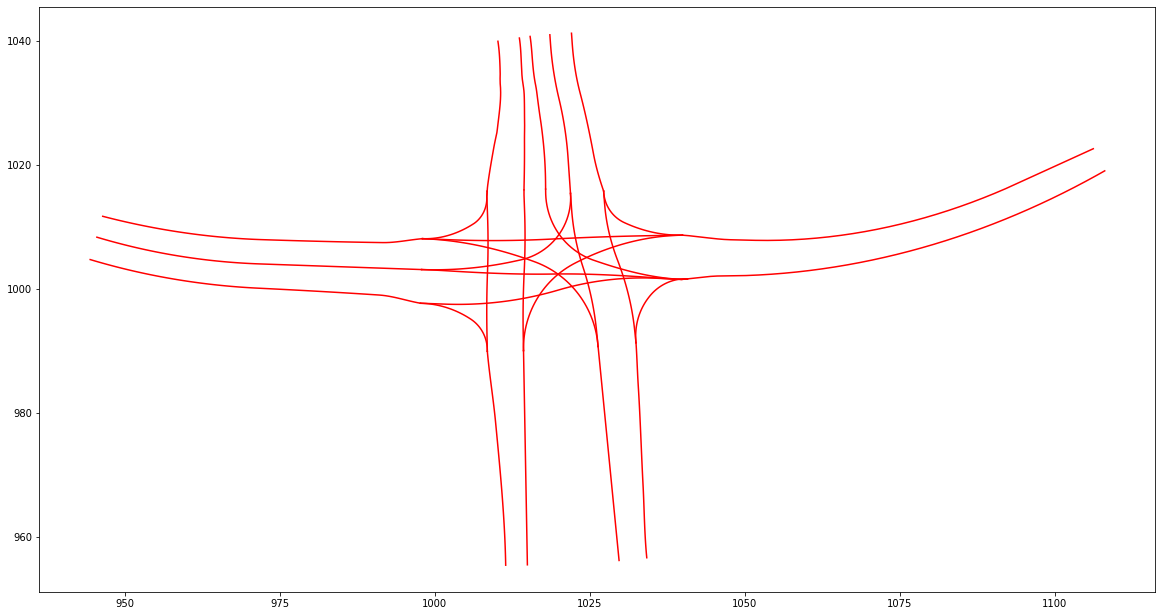

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.set_aspect('equal') 

for link in mf_xyz:
    plt.plot(link[:, 0], link[:, 1], '-', alpha=1, color='r')

### 3.4 设置信控信息

In [11]:
tl_lane_state = [[] for _ in range(11)]
tl_lane_id = [[] for _ in range(11)]
tl_stop_point = [[] for _ in range(11)]

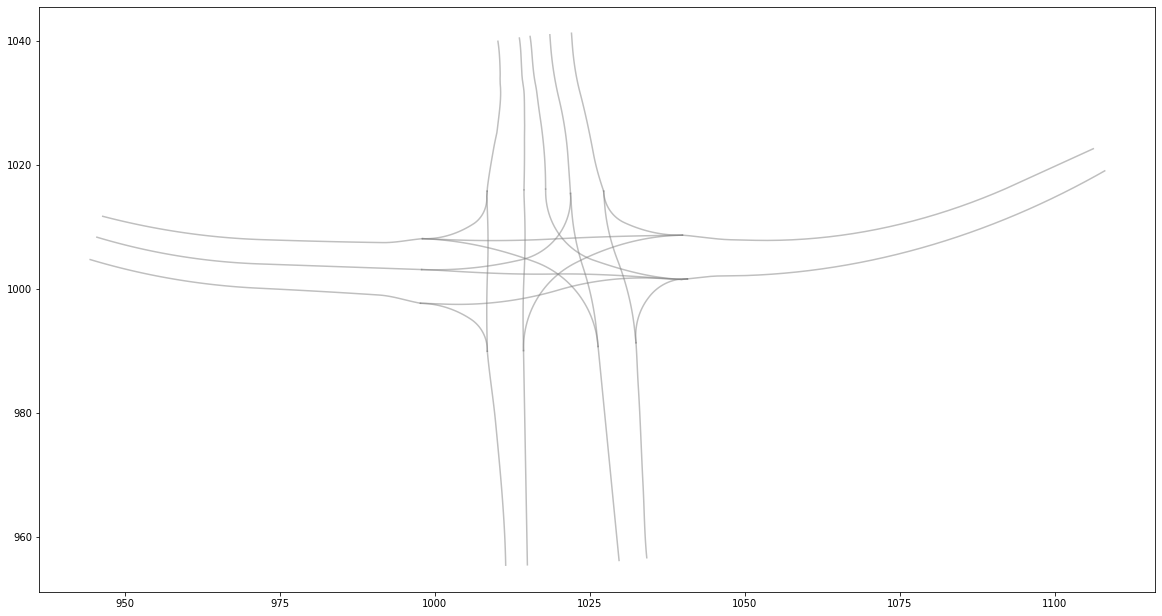

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.set_aspect('equal') 

# 绘制道路中心线
for i in range(len(mf_id)):
    if mf_type[i] == 1:
        link = mf_xyz[i]
        plt.plot([p[0] for p in link], [p[1] for p in link], '-', alpha=0.5, color='grey')
        # plt.text(link[int(len(link) / 2)][0], link[int(len(link) / 2)][1], str(mf_id[i]), ha='center', va='center', fontsize=8, color='black')

# 绘制某一帧的信控状态
frame = 0
light_color = ['blue', 'red', 'yellow', 'green', 'blue']
for i in range(len(tl_lane_id[frame])):
    lane_idx = np.where(np.array(mf_id) == tl_lane_id[frame][i])[0][0]
    lane_xyz = mf_xyz[lane_idx]
    plt.plot([p[0] for p in lane_xyz], [p[1] for p in lane_xyz], '-', alpha=0.8, color=light_color[tl_lane_state[frame][i]])
    plt.plot(tl_stop_point[frame][i][0], tl_stop_point[frame][i][1], 'o', alpha=1, color=light_color[tl_lane_state[frame][i]])

plt.show()

### 3.5 通过xosc获取车辆初始状态信息

In [13]:
import math
from xml.dom.minidom import parse

In [14]:
class AgentInfo:
    def __init__(self, id, name, type):
        self.id = id
        self.name = name
        self.type = type
        self.length = 0.0
        self.width = 0.0
        self.height = 0.0
        # t: [center_x, center_y, center_z, heading, velocity_x, velocity_y]
        self.traj = {}
    
    def set_ego_traj(self, x, y, h, v):
        v = abs(v)
        h = self._normalize_h(h)
        self.traj[0.0] = np.array([x, y, 0.0, h, v * math.cos(h), v * math.sin(h)])
    
    def set_other_traj(self, times, trajs):
        for time, traj in zip(times, trajs):
            self.traj[time] = traj
    
    # [center_x, center_y, center_z, length, width, height, heading, velocity_x, velocity_y, valid]
    def get_traj_info(self, start_time, end_time, dt = 0.1):
        trajs = []
        t = start_time
        while (t <= end_time):
            cur_state = self.traj.get(t, None)
            if cur_state is not None:
                trajs.append([
                    cur_state[0], cur_state[1], cur_state[2],
                    self.length, self.width, self.height,
                    cur_state[3], cur_state[4], cur_state[5], 1
                ])
            else:
                trajs.append([
                    0.0, 0.0, 0.0, self.length, self.width, self.height, 0.0, 0.0, 0.0, 0
                ])
            t += dt
        return trajs

    @staticmethod
    def _normalize_h(h):
        return ((h % (2 * math.pi)) + 2 * math.pi) % (2 * math.pi)
        


In [15]:
agents = {}

opens = parse(xosc_path).documentElement
objects = opens.getElementsByTagName('ScenarioObject')
for idx, object_ in enumerate(objects):
    agent_name = object_.getAttribute("name")
    category_elements = object_.getElementsByTagName('Vehicle')
    if category_elements:
        agent_type = category_elements[0].getAttribute("vehicleCategory")
    else:
        agent_type = "pedestrian"
        
    agent = AgentInfo(idx, agent_name, agent_type)
    dimension_element = object_.getElementsByTagName('Dimensions')[0]
    for k, v in dimension_element.attributes.items():
        agent.__setattr__(k, float(v))

    agents[agent_name] = agent
    
# 读取本车信息
ego_node = opens.getElementsByTagName('Private')[0]
ego_init = ego_node.childNodes[3].data
ego_v, ego_x, ego_y, ego_head = [float(i.split('=')[1]) for i in ego_init.split(',')]
agents['Ego'].set_ego_traj(ego_x, ego_y, ego_head, ego_v)

# 读取背景车信息
select_keys = ['x', 'y', 'z', 'h']
acts = opens.getElementsByTagName('Act')
for act in acts:
    agent_name = act.getAttribute("name").split('_')[-1]

    times = []
    trajs = []
    for status in act.getElementsByTagName('Vertex'):
        loc = status.getElementsByTagName('WorldPosition')[0]
        times.append(round(float(status.getAttribute('time')), 3))
        trajs.append([loc.getAttribute(key) for key in ['x', 'y', 'z', 'h']])
    
    times = np.array(times, dtype=float)
    trajs = np.array(trajs, dtype=float)
    trajs = np.concatenate([
            trajs[:-1], 
            (np.diff(trajs[:, 0]) / np.diff(times))[:, None], 
            (np.diff(trajs[:, 1]) / np.diff(times))[:, None]
        ], 
        axis=-1
    )
    agents[agent_name].set_other_traj(times, trajs)

In [16]:
TYPES = ['car', 'pedestrian', 'bicycle']
agent_id = []
agent_type = []
agent_role = []
agent_states = []
for agent in agents.values():
    agent_id.append(agent.id)
    agent_type.append(TYPES.index(agent.type))
    if agent.name == 'Ego':
        agent_role.append([True, False, False])
    else:
        agent_role.append([False, False, False])
    agent_states.append(agent.get_traj_info(0, 1))

In [17]:
# id [agent_num]
print(np.array(agent_id).shape)

# type [agent_num]
# [TYPE_VEHICLE=0, TYPE_PEDESTRIAN=1, TYPE_CYCLIST=2]
print(np.array(agent_type).shape)

# state [agent_num, frames, 10]
# [center_x, center_y, center_z, length, width, height, heading, velocity_x, velocity_y, valid]
print(np.array(agent_states).shape)

# role [agent_num, 3]
# 0 - 是否为主车
# 1 - 是否为objects_of_interest（可能对研究训练有用的行为的对象）
# 2 - 是否为tracks_to_predict（必须预测的对象，仅在训练集和验证集中提供）
print(np.array(agent_role).shape)

(23,)
(23,)
(23, 11, 10)
(23, 3)


### 3.6 将上述提取的信息预处理为batch数据

In [18]:
import src.utils.pack_h5 as pack_utils

N_PL_TYPE = 11
DIM_VEH_LANES = [0, 1, 2]
DIM_CYC_LANES = [3]
DIM_PED_LANES = [4]

N_TL_STATE = 5

N_PL_MAX = 3000
N_TL_MAX = 40
N_AGENT_MAX = 1300

N_PL = 1024
N_TL = 100
N_AGENT = 64
N_AGENT_NO_SIM = 256

THRESH_MAP = 500  # ! 120
THRESH_AGENT = 120

N_STEP = 91
STEP_CURRENT = 10

pack_all = False
pack_history = True


episode = {}
n_pl = pack_utils.pack_episode_map(
    episode=episode, mf_id=mf_id, mf_xyz=mf_xyz, mf_type=mf_type, mf_edge=mf_edge, n_pl_max=N_PL_MAX
)
n_tl = pack_utils.pack_episode_traffic_lights(
    episode=episode,
    tl_lane_state=tl_lane_state,
    tl_lane_id=tl_lane_id,
    tl_stop_point=tl_stop_point,
    pack_all=pack_all,
    pack_history=pack_history,
    n_tl_max=N_TL_MAX,
    step_current=STEP_CURRENT,
)
n_agent = pack_utils.pack_episode_agents(
    episode=episode,
    agent_id=agent_id,
    agent_type=agent_type,
    agent_states=agent_states,
    agent_role=agent_role,
    pack_all=pack_all,
    pack_history=pack_history,
    n_agent_max=N_AGENT_MAX,
    step_current=STEP_CURRENT,
)
scenario_center, scenario_yaw = pack_utils.center_at_sdc(episode)

episode_reduced = {}
pack_utils.filter_episode_map(episode, N_PL, THRESH_MAP, thresh_z=5)
episode_with_map = episode["map/valid"].any(1).sum() > 0
pack_utils.repack_episode_map(episode, episode_reduced, N_PL, N_PL_TYPE)

pack_utils.filter_episode_traffic_lights(episode)
pack_utils.repack_episode_traffic_lights(episode, episode_reduced, N_TL, N_TL_STATE)

mask_sim, mask_no_sim = pack_utils.filter_episode_agents(
    episode=episode,
    episode_reduced=episode_reduced,
    n_agent=N_AGENT,
    prefix="history/",
    dim_veh_lanes=DIM_VEH_LANES,
    dist_thresh_agent=THRESH_AGENT,
    step_current=STEP_CURRENT,
)
episode_reduced["map/boundary"] = pack_utils.get_map_boundary(
    episode_reduced["map/valid"], episode_reduced["map/pos"]
)

pack_utils.repack_episode_agents(episode, episode_reduced, mask_sim, N_AGENT, "history/")
pack_utils.repack_episode_agents_no_sim(
    episode, episode_reduced, mask_no_sim, N_AGENT_NO_SIM, "history/"
)

In [19]:
n_step = 91
n_step_history = 11
n_agent = 64
n_agent_no_sim = 256
n_pl = 1024
n_tl = 100
n_tl_stop = 40
n_pl_node = 20

tensor_size_test = {
    # object_id for waymo metrics
    "history/agent/object_id": (n_agent,),
    "history/agent_no_sim/object_id": (n_agent_no_sim,),
    # agent_sim
    "history/agent/valid": (n_step_history, n_agent),  # bool,
    "history/agent/pos": (n_step_history, n_agent, 2),  # float32
    "history/agent/z": (n_step_history, n_agent, 1),  # float32
    "history/agent/vel": (n_step_history, n_agent, 2),  # float32, v_x, v_y
    "history/agent/spd": (n_step_history, n_agent, 1),  # norm of vel, signed using yaw_bbox and vel_xy
    "history/agent/acc": (n_step_history, n_agent, 1),  # m/s2, acc[t] = (spd[t]-spd[t-1])/dt
    "history/agent/yaw_bbox": (n_step_history, n_agent, 1),  # float32, yaw of the bbox heading
    "history/agent/yaw_rate": (n_step_history, n_agent, 1),  # rad/s, yaw_rate[t] = (yaw[t]-yaw[t-1])/dt
    "history/agent/type": (n_agent, 3),  # bool one_hot [Vehicle=0, Pedestrian=1, Cyclist=2]
    "history/agent/role": (n_agent, 3),  # bool [sdc=0, interest=1, predict=2]
    "history/agent/size": (n_agent, 3),  # float32: [length, width, height]
    "history/agent_no_sim/valid": (n_step_history, n_agent_no_sim),
    "history/agent_no_sim/pos": (n_step_history, n_agent_no_sim, 2),
    "history/agent_no_sim/z": (n_step_history, n_agent_no_sim, 1),
    "history/agent_no_sim/vel": (n_step_history, n_agent_no_sim, 2),
    "history/agent_no_sim/spd": (n_step_history, n_agent_no_sim, 1),
    "history/agent_no_sim/yaw_bbox": (n_step_history, n_agent_no_sim, 1),
    "history/agent_no_sim/type": (n_agent_no_sim, 3),
    "history/agent_no_sim/size": (n_agent_no_sim, 3),
    # map
    "map/valid": (n_pl, n_pl_node),  # bool
    "map/type": (n_pl, 11),  # bool one_hot
    "map/pos": (n_pl, n_pl_node, 2),  # float32
    "map/dir": (n_pl, n_pl_node, 2),  # float32
    "map/boundary": (4,),  # xmin, xmax, ymin, ymax
    # traffic_light
    "history/tl_lane/valid": (n_step_history, n_tl),  # bool
    "history/tl_lane/state": (n_step_history, n_tl, 5),  # bool one_hot
    "history/tl_lane/idx": (n_step_history, n_tl),  # int, -1 means not valid
    "history/tl_stop/valid": (n_step_history, n_tl_stop),  # bool
    "history/tl_stop/state": (n_step_history, n_tl_stop, 5),  # bool one_hot
    "history/tl_stop/pos": (n_step_history, n_tl_stop, 2),  # x,y
    "history/tl_stop/dir": (n_step_history, n_tl_stop, 2),  # dx,dy
}

In [20]:
batch = {
    "episode_idx": str(0),
    "scenario_id": scenario_id,
    "scenario_center": torch.Tensor([scenario_center]),
    "scenario_yaw": torch.Tensor(np.array([scenario_yaw])),
    "with_map": torch.Tensor([episode_with_map]),
}
for k, _size in tensor_size_test.items():
    batch[k] = torch.from_numpy(np.ascontiguousarray(episode_reduced[k]))[tf.newaxis]

/tmp/ipykernel_424756/3768009079.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  "scenario_center": torch.Tensor([scenario_center]),
/tmp/ipykernel_424756/3768009079.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "with_map": torch.Tensor([episode_with_map]),


### 3.7 绘制初始车辆及轨迹信息

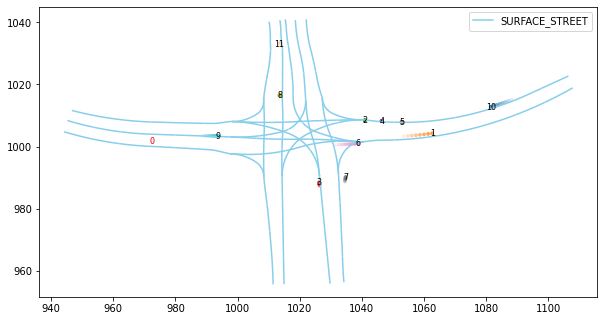

In [24]:
import matplotlib.pyplot as plt
from utils.transform_utils import torch_pos2global, torch_rad2rot, torch_dir2global

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect('equal')

# 绘制目标线段
scenario_center = batch["scenario_center"].unsqueeze(1)  # [n_sc, 1, 2]
scenario_rot = torch_rad2rot(batch["scenario_yaw"])  # [n_sc, 2, 2]

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#C0C0C0', '#800000', '#008000', '#000080', '#808000']  
types = ["FREEWAY", "SURFACE_STREET", "STOP_SIGN", "BIKE_LANE", "ROAD_EDGE_BOUNDARY", "ROAD_EDGE_MEDIAN", "BROKEN", "SOLID_SINGLE", "DOUBLE", "SPEED_BUMP", "CROSSWALK"]
plot_type = [False] * len(types)

for cur_type in range(len(types)):
# for cur_type in [1]:
    for i in range(batch['map/valid'].shape[1]):
        if tf.argmax(batch['map/type'], axis=-1)[0, i] == cur_type and tf.reduce_any(batch['map/valid'][0, i]):
            nodes_pos = torch_pos2global(batch['map/pos'][:, i][batch['map/valid'][:, i]], scenario_center, scenario_rot)
            if plot_type[cur_type]:
                plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type])
            else:
                plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type], label=types[cur_type])
                plot_type[cur_type] = True
            
            # plt.text(nodes_pos[0, int(nodes_pos.shape[1]/2), 0], nodes_pos[0, int(nodes_pos.shape[1]/2), 1], i, ha='center', va='center', fontsize=8, color='black')
            
            # 展示每个点的dir信息
            # nodes_yaw = torch_dir2global(batch['map/dir'][:, i][batch['map/valid'][:, i]], scenario_rot)
            # for k in range(nodes_pos.shape[1]):
            #     plt.plot([nodes_pos[0, k, 0], nodes_pos[0, k, 0] + nodes_yaw[0, k, 0]*15], 
            #             [nodes_pos[0, k, 1], nodes_pos[0, k, 1] + nodes_yaw[0, k, 1]*15], '-', linewidth=1, color='#653700')

# 绘制代理
agent_history_global = torch_pos2global(batch['history/agent/pos'], scenario_center, scenario_rot)[0]
alpha_values = np.linspace(0.1, 1.0, agent_history_global.shape[0]) 

for i in range(agent_history_global.shape[1]):
    x = agent_history_global[:, i, 0][batch['history/agent/valid'][0, :, i]]
    y = agent_history_global[:, i, 1][batch['history/agent/valid'][0, :, i]]
    if x.shape[0] > 0 and y.shape[0] > 0:
        plt.scatter(x, y, s=8, marker='o', alpha=alpha_values)
        if (batch['history/agent/role'][0, i, 0]):
            plt.text(x[-1], y[-1], str(int(batch['history/agent/object_id'][0, i])), ha='center', va='center', fontsize=8, color='red')
        else:
            plt.text(x[-1], y[-1], str(int(batch['history/agent/object_id'][0, i])), ha='center', va='center', fontsize=8, color='black')


plt.legend()
plt.show()

### 2.6 为每个代理设置期望目的地

In [ ]:
# 设定每个代理的期望终点
goal_expect = [239, 269, 269, 269, 269]

# 验证代理终点信息
valid_agent_id = batch['history/agent/object_id'][batch['history/agent/valid'].any(1)]
assert valid_agent_id.shape[0] == len(goal_expect)

for id, goal in zip(valid_agent_id, goal_expect):
    print(f"{id} -d-> {goal}")

556 -d-> 239
370 -d-> 269
371 -d-> 269
372 -d-> 269
369 -d-> 269


In [ ]:
# 绘制代理终点情况
import matplotlib.pyplot as plt
from waymo_open_dataset.utils.sim_agents import visualizations
from utils.transform_utils import torch_pos2global, torch_rad2rot, torch_rad2global

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 绘制静态地图
visualizations.add_map(ax, scenario)

scenario_center = batch["scenario_center"].unsqueeze(1)  # [n_sc, 1, 2]
scenario_rot = torch_rad2rot(batch["scenario_yaw"])  # [n_sc, 2, 2]


# 绘制代理
agent_history_global = torch_pos2global(batch['history/agent/pos'], scenario_center, scenario_rot)[0]
alpha_values = np.linspace(0.1, 1.0, agent_history_global.shape[0]) 

for i in range(agent_history_global.shape[1]):
    x = agent_history_global[:, i, 0][batch['history/agent/valid'][0, :, i]]
    y = agent_history_global[:, i, 1][batch['history/agent/valid'][0, :, i]]
    if x.shape[0] > 0 and y.shape[0] > 0:
        plt.scatter(x, y, s=8, marker='o', alpha=alpha_values)
        if (batch['history/agent/role'][0, i, 0]):
            plt.text(x[-1], y[-1], str(int(batch['history/agent/object_id'][0, i])), ha='center', va='center', fontsize=8, color='red')
        else:
            plt.text(x[-1], y[-1], str(int(batch['history/agent/object_id'][0, i])), ha='center', va='center', fontsize=8, color='black')

# 绘制终点
for i in goal_expect:
    if tf.argmax(batch['map/type'], axis=-1)[0, i] == cur_type and tf.reduce_any(batch['map/valid'][0, i]):
        nodes_pos = torch_pos2global(batch['map/pos'][:, i][batch['map/valid'][:, i]], scenario_center, scenario_rot)
        if plot_type[cur_type]:
            plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type])
        else:
            plt.plot(nodes_pos[0, :, 0], nodes_pos[0, :, 1], '-', alpha=1, color=colors[cur_type], label=types[cur_type])
            plot_type[cur_type] = True
        
        plt.text(nodes_pos[0, int(nodes_pos.shape[1]/2), 0], nodes_pos[0, int(nodes_pos.shape[1]/2), 1], i, ha='center', va='center', fontsize=8, color='black')

plt.show()
            

### 3.8 运行闭环仿真

In [29]:
import torch

model.eval()
with torch.no_grad():
    rollout = model.ego_test_loop_for_onsite(
        origin_batch=batch, 
        controller=cur_controller, 
        # goal = goal_expect,
        goal = None,
        sim_duration=90,
        k_futures = 1,
        print_info=True,
        rule_checker=False,
    )

frame 1: [acc=-0.899, rot= 0.000]
frame 2: [acc= 1.759, rot= 0.000]
frame 3: [acc= 1.759, rot= 0.000]
frame 4: [acc= 1.759, rot= 0.000]
frame 5: [acc= 1.759, rot= 0.000]
frame 6: [acc= 1.759, rot= 0.000]
frame 7: [acc= 1.759, rot= 0.000]
frame 8: [acc= 1.763, rot= 0.000]
frame 9: [acc= 1.767, rot= 0.000]
frame 10: [acc= 1.771, rot= 0.000]
frame 11: [acc= 1.773, rot= 0.000]
frame 12: [acc= 1.775, rot= 0.000]
frame 13: [acc= 1.776, rot= 0.000]
frame 14: [acc= 1.776, rot= 0.000]
frame 15: [acc= 1.776, rot= 0.000]
frame 16: [acc= 1.776, rot= 0.000]
frame 17: [acc= 1.776, rot= 0.000]
frame 18: [acc= 1.776, rot= 0.000]
frame 19: [acc= 1.776, rot= 0.000]
frame 20: [acc= 1.776, rot= 0.000]
frame 21: [acc= 1.776, rot= 0.000]
frame 22: [acc= 1.776, rot= 0.000]
frame 23: [acc= 1.776, rot= 0.000]
frame 24: [acc= 1.776, rot= 0.000]
frame 25: [acc= 1.776, rot= 0.000]
frame 26: [acc= 1.776, rot= 0.000]
frame 27: [acc= 1.777, rot= 0.000]
frame 28: [acc= 1.777, rot= 0.000]
frame 29: [acc= 1.778, rot= 0

### 3.9 仿真结果可视化

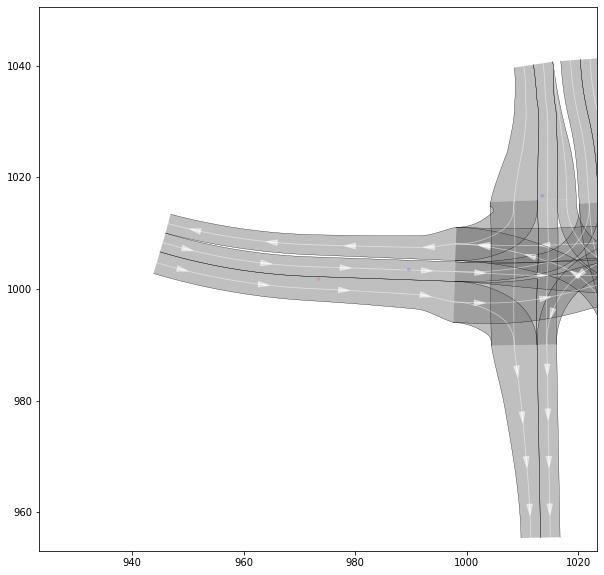

In [48]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from utils.visualizer import plot_xodr_map

alpha_values = np.linspace(0.1, 0.8, 11) 
scenario_center = batch["scenario_center"].unsqueeze(1)
scenario_rot = torch_rad2rot(batch["scenario_yaw"])
preds = torch_pos2global(rollout.preds[..., :2], scenario_center, scenario_rot)

fig, ax_map_bg = plt.subplots(1, 1, figsize=(10, 10))
ax_map_bg.set_aspect('equal')
plot_xodr_map(ax_map_bg, xodr_path, draw_arrow=True)

ax_objects = ax_map_bg.twinx()

def update_objects(timestep):
    # ax_map_bg.set_xlim(preds[0, 0, 0, timestep, 0] - 50, preds[0, 0, 0, timestep, 0] + 50)
    # ax_map_bg.set_ylim(preds[0, 0, 0, timestep, 1] - 50, preds[0, 0, 0, timestep, 1] + 50)

    ax_objects.cla()
    ax_objects.axis('off')
    ax_objects.set_ylim(ax_map_bg.get_ylim())
    ax_objects.set_aspect('equal')

    for i in range(rollout.valid.shape[1]):
        if i == 0:
            color = 'red'
        else:
            color = 'blue'
        if (rollout.valid[0, i, 0, timestep]):
            x = preds[0, i, 0, max(0, timestep-10):timestep+1, 0]
            y = preds[0, i, 0, max(0, timestep-10):timestep+1, 1]
            ax_objects.scatter(x, y, s=8, marker='o', alpha=alpha_values, color=color)
            ax_objects.text(x[-1], y[-1], str(int(batch['history/agent/object_id'][0, i])), ha='center', va='center', fontsize=8, color='black')
    return ax_objects,

# 创建动画  
ani = FuncAnimation(fig, update_objects, frames=np.arange(90), blit=False)  
ani.save('./videos/animation.mp4', writer='ffmpeg', fps=10)
        

## 可视化

### 地图可视化

In [9]:
import matplotlib.pyplot as plt
from waymo_open_dataset.utils.sim_agents import visualizations

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
visualizations.add_map(ax, scenario)

plt.show()

### 场景实时可视化

In [10]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

# Set matplotlib to jshtml so animations work with colab.
from matplotlib import rc
rc('animation', html='jshtml')

In [11]:
from waymo_open_dataset.utils.sim_agents import visualizations

class Visualizer:
    def __init__(self, scenario):
        # 创建画布
        self.fig, self.ax_map_bg = plt.subplots(1, 1, figsize=(10, 10))
        # 创建动态元素图层
        self.ax_objects = self.ax_map_bg.twinx()

        # 绘制静态地图
        self._plot_static_map(self.ax_map_bg, scenario)
        
    @staticmethod
    def _plot_static_map(ax, scenario):
        visualizations.add_map(ax, scenario)

    def _update_dynamic(self, preds, valid):
        self.ax_objects.cla()
        self.ax_objects.set_ylim(self.ax_map_bg.get_ylim())
        self.ax_objects.axis('off')

        for agent_id in range(preds.shape[0]):
            if valid[agent_id]:
                self.ax_objects.plot(preds[agent_id, 0], preds[agent_id, 1], 'o', markersize=6, c='grey')
                self.ax_objects.text(preds[agent_id, 0], preds[agent_id, 1], str(agent_id), ha='center', va='center', fontsize=6, color='black')
        plt.show()

In [12]:
from utils.transform_utils import torch_pos2global, torch_rad2rot, torch_rad2global

scenario_center = batch["scenario_center"].unsqueeze(1)
scenario_rot = torch_rad2rot(batch["scenario_yaw"])

sim_pos_global = torch_pos2global(rollout.preds[0, :, :, 0, :2], scenario_center, scenario_rot)[:, 0, :]
sim_yaw_global = torch_rad2global(rollout.preds[0, :, :, 0, 2:3], batch["scenario_yaw"])[:, 0, :]

vis = Visualizer(scenario)
vis._update_dynamic(sim_pos_global, rollout.valid[0, :, 0, 0])